In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from Heston_util import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on {device}")

running on cuda


In [3]:
sequence_length = 30
dt = 1/365
learning_rate = 0.005
batch_size = 10000

sigma = 2
T = dt * sequence_length
K = 100
s0 = 100
v0 = 0.04
alpha = 1.
b = 0.04
rho = -0.7
alpha_loss = 0.5
transaction_cost_rate = 0.0

In [4]:
def performance(network, S, V, VarPrice):
    network.eval()
    input_vector = torch.cat((torch.log(S[:, :-1]).unsqueeze(-1), V[:, :-1].unsqueeze(-1)), dim=-1)
    holding = network(input_vector).squeeze()
    delta_S = S[:, 1:] - S[:, :-1]
    delta_V = VarPrice[:, 1:] - VarPrice[:, :-1]
    delta_price = torch.cat((delta_S.unsqueeze(-1), delta_V.unsqueeze(-1)), dim=2)
    PnL = (holding * delta_price).sum(dim=(1,2))
    C_T = loss_fn.terminal_payoff(S[:,-1])
    X = -PnL + C_T    
    p0 = find_optimal_p0(X,alpha_loss)
    X = X - p0  
    return (torch.max(X, torch.zeros_like(X)).mean().item()/0.5+p0)

In [5]:
generator = PathGeneratorHeston(s0=s0, v0=v0, alpha=alpha, b=b, sigma=sigma, rho=rho, timestep=sequence_length, T=T)
loss_fn = loss_CVAR(Strike_price=K, vol=sigma, T=T, alpha_loss=alpha_loss, trans_cost_rate=transaction_cost_rate, p0_mode='search').to(device=device)
attacker = Heston_Attacker(loss_fn=loss_fn, s0=s0, v0=v0, alpha=alpha, b=b, sigma=sigma, rho=rho, timestep=sequence_length, T=T)

In [6]:
# Load the data
data = torch.load('../Data/Heston_test.pt') # Load the data from the .pt file
N=100000 # Number of samples
S, V, VarPrice = data[0][:N], data[1][:N], data[2][:N] 
S,V,VarPrice = S.to(device), V.to(device), VarPrice.to(device)

In [7]:
# Load the network
network = RNN_BN_simple(sequence_length=sequence_length).to(device=device)
network.eval()
network.load_state_dict(torch.load('../Result/Heston.pth'))

<All keys matched successfully>

In [8]:
# Evaluate the performance of the network
result = performance(network, S, V, VarPrice)
print(result)

1.9279827624559402


In [9]:
# Evaluate the performance of the network under WBPGD S-Attack
delta_list = [0,0.01,0.03,0.05,0.1,0.3,0.5]
att_S_budget_S = []
for delta in delta_list:
    S_att, V_att, VarPrice_att = attacker.S_budget_attack(network, S, V, delta, 4, 20)
    result = performance(network, S_att, V_att, VarPrice_att)
    att_S_budget_S .append(S_att)
    print(result)


1.9279824793338776
1.9641979336738586
2.043216824531555
2.1356025636196136
2.446583330631256
4.5771191120147705
8.074510097503662


In [10]:
# Evaluate the performance of the network under WBPGD SV-Attack
delta_list = [0,0.01,0.03,0.05,0.1,0.3,0.5]
att_SV_budget_S = []
att_SV_budget_V = []
for delta in delta_list:
    S_att, V_att, VarPrice_att = attacker.SV_budget_attack(network, S, V, delta, 4, 20)
    result = performance(network, S_att, V_att, VarPrice_att)
    att_SV_budget_S.append(S_att)
    att_SV_budget_V.append(V_att)
    print(result)

1.9279824793338776
1.9659345149993896
2.048535019159317
2.145141452550888
2.4659844636917114
4.589833617210388
7.739052057266235


In [11]:
# Evaluate the performance of the network under WPGD S-Attack
delta_list = [0,0.01,0.03,0.05,0.1,0.3,0.5]
att_S_PGD=[]
for delta in delta_list:
    S_att, V_att, VarPrice_att = attacker.net_W2_att_S(network, S, V, VarPrice,delta, 4, 20)
    result = performance(network, S_att, V_att, VarPrice_att)
    print(result)

1.9279827624559402
1.9642028510570526
2.0431241393089294
2.134311258792877
2.4369224309921265
4.5148255825042725
7.541116714477539


In [12]:
# Evaluate the performance of the network under WPGD SV-Attack
delta_list = [0,0.01,0.03,0.05,0.1,0.3,0.5]
for delta in delta_list:
    S_att, V_att, VarPrice_att = attacker.net_W2_att_SV(network, S[:100000], V[:100000], delta/1.414, 4, 20)
    result = performance(network, S_att, V_att, VarPrice_att)
    print(result)

1.9279824793338776
1.9651958048343658
2.045707583427429
2.137827545404434
2.439279556274414
4.480247616767883
7.467813968658447


In [13]:
# Functions to compare the original and attacked data
def to_numpy(x: torch.tensor) -> np.array:
    return x.detach().cpu().numpy()


def cov(x, rowvar=False, bias=True, ddof=None, aweights=None):
    x = to_numpy(x)
    _, L, C = x.shape
    x = x.reshape(-1, L*C)
    return torch.from_numpy(np.cov(x, rowvar=False)).float()


def cov_diff(x_real, x_fake):
    cov_real, cov_fake = cov(x_real), cov(x_fake)
    return torch.norm(cov_real - cov_fake, p = 'fro')


def acf(x, lag, dim=(0, 1)):
    acf_list = list()
    x = x - x.mean((0, 1))
    std = torch.var(x, unbiased=False, dim=(0, 1))
    for i in range(lag):
        y = x[:, i:] * x[:, :-i] if i > 0 else torch.pow(x, 2)
        acf_i = torch.mean(y, dim) / std
        acf_list.append(acf_i)
    if dim == (0, 1):
        return torch.stack(acf_list)
    else:
        return torch.cat(acf_list, 1)

In [14]:
# ACF
acf_S_budget_S = [acf(S_att, 30) for S_att in att_S_budget_S]
acf_SV_budget_S = [acf(S_att, 30) for S_att in att_SV_budget_S]
acf_SV_budget_V = [acf(V_att, 30) for V_att in att_SV_budget_V]

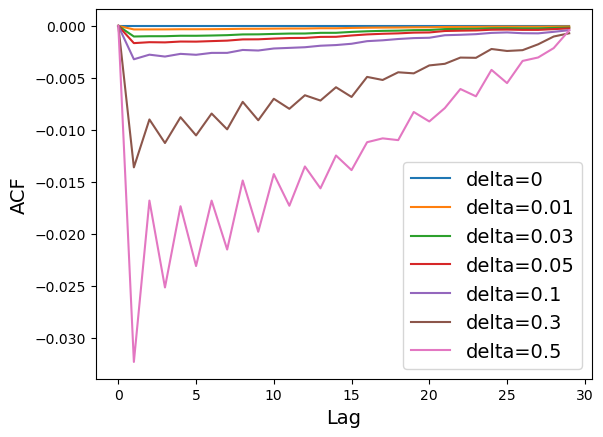

In [15]:
# ACF plot 
for n in range(len(acf_S_budget_S)):
    plt.plot(acf_S_budget_S[n].cpu().numpy() - acf_S_budget_S[0].cpu().numpy(), label='delta='+str([0,0.01,0.03,0.05,0.1,0.3,0.5][n]))
plt.legend(fontsize=14)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.show()

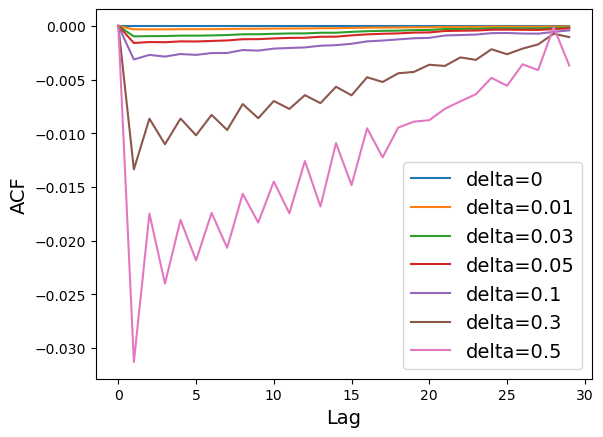

In [16]:
# ACF plot 
for n in range(len(acf_S_budget_S)):
    plt.plot(acf_SV_budget_S[n].cpu().numpy()-acf_SV_budget_S[0].cpu().numpy(), label='delta='+str([0,0.01,0.03,0.05,0.1,0.3,0.5][n]))
plt.legend(fontsize=14)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.show()

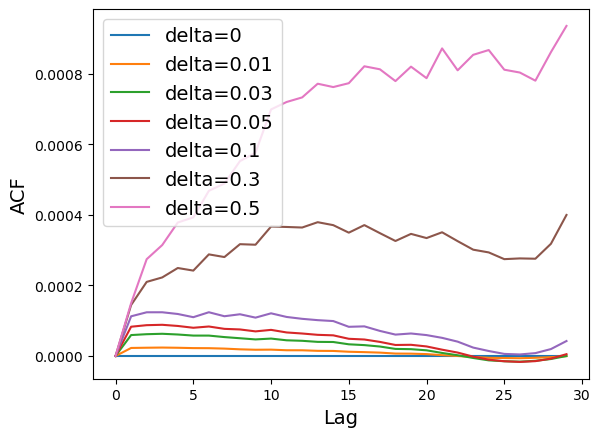

In [17]:
# ACF plot 
for n in range(len(acf_S_budget_S)):
    plt.plot(acf_SV_budget_V[n].cpu().numpy()-acf_SV_budget_V[0].cpu().numpy(), label='delta='+str([0,0.01,0.03,0.05,0.1,0.3,0.5][n]))
plt.legend(fontsize=14)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.show()

In [18]:
# Covariance difference for S-attack
SV = torch.cat((S.unsqueeze(-1), V.unsqueeze(-1)), dim=-1)
plots_S = []
for n in range(1,len(att_S_budget_S)):
    S_att = att_S_budget_S[n]
    V_att = V
    SV_att = torch.cat((S_att.unsqueeze(-1), V_att.unsqueeze(-1)), dim=-1)
    print(cov_diff(SV, SV_att).item())
    plots_S.append(cov_diff(SV, SV_att).item())


0.17522986233234406
0.4882458448410034
0.729802131652832
1.124552845954895
2.5176641941070557
4.353194236755371


In [19]:
# Covariance difference for SV-attack
SV = torch.cat((S.unsqueeze(-1), V.unsqueeze(-1)), dim=-1)
plots_SV = []
for n in range(1,len(att_S_budget_S)):
    S_att = att_SV_budget_S[n]
    V_att = att_SV_budget_V[n]
    SV_att = torch.cat((S_att.unsqueeze(-1), V_att.unsqueeze(-1)), dim=-1)
    print(cov_diff(SV, SV_att).item())
    plots_SV.append(cov_diff(SV, SV_att).item())


0.16742436587810516
0.46971026062965393
0.7033068537712097
1.113638997077942
2.645374059677124
4.784093379974365
